# Code for the model testing

In [28]:
#### Importation of libraries ####

from datetime import datetime
from datetime import date
from pandas_datareader.data import DataReader
from yahoofinancials import YahooFinancials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import backtrader as bt
import talib
pd.options.mode.chained_assignment = None
import ipympl

# Trading strat and backtesting

In [29]:
#### Download of the csv created with all Sentiment and Financial Data ####

SENT = pd.read_csv('FB.csv', index_col=0)
SENT = SENT['2021-02-01':'2021-11-01']
SENT.head()

,high,low,open,close,volume,neg,neu,pos,compound,Daily References
2021-02-01,264.170013,254.910004,259.519989,262.010010,22914300,0.016500,0.891125,0.092375,0.102462,16
2021-02-02,268.850006,263.269989,264.000000,267.079987,17320800,0.133800,0.770733,0.095467,-0.090300,15
2021-02-03,269.200012,263.839996,265.619995,266.649994,14223400,0.026778,0.873333,0.099889,0.143167,9
2021-02-04,268.160004,264.000000,267.010010,266.489990,16060000,0.124435,0.829348,0.046217,-0.141130,23
2021-02-05,269.170013,265.670013,266.799988,268.100006,12454400,0.066846,0.851154,0.082000,0.022108,13


In [30]:
#### Declaration of References as a Backtrader indicator ####

from backtrader.indicators import Indicator
class Sentiment(bt.Indicator):
    lines = ('sentiment',)
    
    plotinfo = dict(plot=True,
                    subplot=True,
                    plotname='',
               )   
    
    def next(self):
        self.date = self.datas[0].datetime.date(0)
        self.sentiment = SENT['compound'].loc[self.date.strftime('%Y-%m-%d')]
        self.lines.sentiment[0] = SENT['compound'].loc[self.date.strftime('%Y-%m-%d')]

print(type(Sentiment))

<class 'backtrader.indicator.MetaIndicator'>


In [31]:
#### Declaration of References as a Backtrader indicator ####

from backtrader.indicators import Indicator
class References(bt.Indicator):
    lines = ('references',)
    
    plotinfo = dict(plot=True,
                    subplot=True,
                    plotname='',
               )   
    
    def next(self):
        self.date = self.datas[0].datetime.date(0)
        self.references = SENT['Daily References'].loc[self.date.strftime('%Y-%m-%d')]
        self.lines.references[0] = SENT['Daily References'].loc[self.date.strftime('%Y-%m-%d')]

print(type(References))

<class 'backtrader.indicator.MetaIndicator'>


Starting Portfolio Value: 100000.00
2021-02-23, Close, 265.86$, Sentiment 0.038, Daily References 25
2021-02-24, Close, 264.31$, Sentiment -0.024, Daily References 23
2021-02-25, Close, 254.69$, Sentiment 0.087, Daily References 21
2021-03-01, Close, 264.91$, Sentiment 0.113, Daily References 16
2021-03-02, Close, 259.00$, Sentiment -0.006, Daily References 10
2021-03-03, Close, 255.41$, Sentiment -0.027, Daily References 18
2021-03-04, Close, 257.64$, Sentiment -0.123, Daily References 6
2021-03-05, Close, 264.28$, Sentiment 0.203, Daily References 12
2021-03-05, BUY CREATE, 264.28
2021-03-08, BUY EXECUTED, Price: 265.55, Cost: 265.55, Comm 0.27
2021-03-08, Close, 255.31$, Sentiment 0.080, Daily References 13
2021-03-08, SELL CREATE, 255.31
2021-03-09, SELL EXECUTED, Price: 261.18, Cost: 265.55, Comm 0.26
2021-03-09, OPERATION PROFIT, GROSS -4.37, NET -4.90
2021-03-09, Close, 265.74$, Sentiment -0.094, Daily References 18
2021-03-10, Close, 264.90$, Sentiment -0.121, Daily References 

<IPython.core.display.Javascript object>


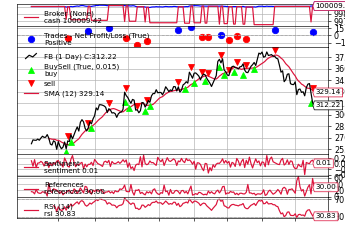

In [34]:
################ STRATEGY BACKTESTING ################

class ThesisStrategy(bt.Strategy):
    
    #### Constant variables #####
    params = (
    ('short_period',12),       
    ('flag',False)
    )
    
    
    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt, txt))
        
        
    
    def __init__(self):
        
        #### Data collection from the feed ####
        self.dataclose = self.datas[0].close
        self.date = self.datas[0].datetime.date(0)
        self.sentiment = Sentiment(self.data).sentiment
        self.references = References(self.data).references
        
        #### Declaration of transaction variables ####
        self.order = None
        self.buyprice = None
        self.buycomm = None
        
        #### Definition of indicators #####
           
        self.SMA = bt.ind.SMA(period=self.params.short_period)
        self.RSI = bt.ind.RSI()
  
        
        
    ##### Trade notification #####
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Trade is done
            return

        #### Check for transaction and print the details ####
        if order.status in [order.Completed, order.Canceled, order.Margin]:
            
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))
                self.bar_executed = len(self)

        
        self.order = None

        
    def notify_trade(self, trade):
        #### Print the results of the transaction (Profit and loss) #### 
        if not trade.isclosed:
            return
        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    

    def next(self):
        #### Daily notification about relevant data ####
        self.log('Close, %.2f$, Sentiment %.3f, Daily References %.0f' % (self.dataclose[0], self.sentiment[0], self.references[0]))
        #### Check for orders proceeding ####
        if self.order:
            return
        
        #### Strategy 2 ####
        
        if not self.position and not self.params.flag: 
            if self.dataclose[0] > self.SMA and not self.position and not self.RSI > 70:
                    self.log('BUY CREATE, %.2f' % self.dataclose[0])
                    self.order = self.buy()
                
        if ((self.dataclose[0] < self.SMA or self.RSI > 70 or self.references > 60 or self.sentiment > 0.3) and self.position):
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                self.params.flag = True
                self.order = self.sell()
                
        if not (self.dataclose[0] < self.SMA or self.RSI > 70 or self.references > 60 or self.sentiment > 0.3):
                self.params.flag = False
                    
            
if __name__ == '__main__':
    cerebro = bt.Cerebro()
    
    #### Loading of the strategy in cerebro ####
    cerebro.addstrategy(ThesisStrategy)
    
    #### Datafeed ####
    data = bt.feeds.GenericCSVData(dataname='FB.csv',
                                  fromdate=datetime(2021,2,1),
                                  todate=datetime(2021,11,1),
                                  nullvalue=0.0,
                                  dtformat=('%Y-%m-%d'),
                                  datetime=0,
                                  high=1,
                                  low=2,
                                  open=3,
                                  close=4,
                                  volume=5,
                                  sentiment=6,
                                  references = 7,
                                  openinterest=-1
                                )
    cerebro.adddata(data)
    
    #### Creation of the portfolio and add of comissions ####
    cerebro.broker.setcash(100000)
    cerebro.broker.setcommission(commission=0.001, margin = 0)

    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    
    #### Run the backtesting #### 
    backtest = cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    
    #### Plot ####
    plt.rcParams['figure.figsize'] = [25, 15]
    plt.rcParams.update({'font.size': 12}) 
    %matplotlib inline
    Backtest_results = cerebro.plot(volume=False)
    plt.savefig('SMA_RSI_SENT_Strategy_2_FB_results.png')
    
    